In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [7]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset


Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!pip install keras_preprocessing


In [9]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

In [10]:
# Import necessary libraries
import os
import zipfile

# Specify the path to your dataset
dataset_path = "/content/face-expression-recognition-dataset.zip"

# Define directories for train and test sets
TRAIN_DIR = 'images/images/train'
TEST_DIR = 'images/images/validation'

# Ensure directories exist
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Unzipping the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('images')  # Extract all files into 'images' folder

# Verify if files are extracted
print(f"Contents of train directory: {os.listdir(TRAIN_DIR)[:5]}")
print(f"Contents of validation directory: {os.listdir(TEST_DIR)[:5]}")


Contents of train directory: ['neutral', 'disgust', 'fear', 'happy', 'angry']
Contents of validation directory: ['neutral', 'disgust', 'fear', 'happy', 'angry']


In [11]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels


In [12]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

neutral completed
disgust completed
fear completed
happy completed
angry completed
surprise completed
sad completed


In [13]:
print(train)

                                       image    label
0       images/images/train/neutral/3805.jpg  neutral
1      images/images/train/neutral/12796.jpg  neutral
2      images/images/train/neutral/11438.jpg  neutral
3      images/images/train/neutral/33872.jpg  neutral
4       images/images/train/neutral/4550.jpg  neutral
...                                      ...      ...
28816       images/images/train/sad/4164.jpg      sad
28817      images/images/train/sad/27210.jpg      sad
28818       images/images/train/sad/2675.jpg      sad
28819      images/images/train/sad/34576.jpg      sad
28820      images/images/train/sad/13490.jpg      sad

[28821 rows x 2 columns]


In [14]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

neutral completed
disgust completed
fear completed
happy completed
angry completed
surprise completed
sad completed


In [15]:
print(test)
print(test['image'])

                                           image    label
0     images/images/validation/neutral/24820.jpg  neutral
1      images/images/validation/neutral/4883.jpg  neutral
2      images/images/validation/neutral/5853.jpg  neutral
3       images/images/validation/neutral/649.jpg  neutral
4     images/images/validation/neutral/20150.jpg  neutral
...                                          ...      ...
7061      images/images/validation/sad/25983.jpg      sad
7062      images/images/validation/sad/10375.jpg      sad
7063      images/images/validation/sad/15909.jpg      sad
7064       images/images/validation/sad/9498.jpg      sad
7065      images/images/validation/sad/33421.jpg      sad

[7066 rows x 2 columns]
0       images/images/validation/neutral/24820.jpg
1        images/images/validation/neutral/4883.jpg
2        images/images/validation/neutral/5853.jpg
3         images/images/validation/neutral/649.jpg
4       images/images/validation/neutral/20150.jpg
                        

In [16]:
from tqdm.notebook import tqdm

In [17]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,grayscale =  True )
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features


In [18]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [19]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [20]:
x_train = train_features/255.0
x_test = test_features/255.0

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [23]:
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [24]:
y_train = to_categorical(y_train,num_classes = 7)
y_test = to_categorical(y_test,num_classes = 7)

In [25]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])  # Use a list for metrics


In [27]:
# model.fit(x= x_train,y = y_train, batch_size = 128, epochs = 100, validation_data = (x_test,y_test))

In [28]:
model_json = model.to_json()
with open("/content/emotiondetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("/content/emotiondetector.h5")

In [29]:
from tensorflow.keras.models import Sequential, model_from_json

# Open and read the JSON file
json_file = open("/content/facialemotionmodel.json", "r")
model_json = json_file.read()
json_file.close()

# Deserialize the model with custom_objects
model = model_from_json(model_json, custom_objects={"Sequential": Sequential})

# Load weights into the model
model.load_weights("/content/facialemotionmodel.h5")
print("Model loaded successfully")


Model loaded successfully


In [30]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [31]:
def ef(image):
    img = load_img(image,grayscale =  True )
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0


In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is of sad


/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
model prediction is  sad


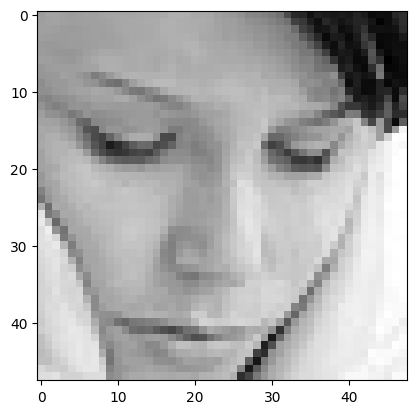

In [33]:
image = '/content/images/images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
model prediction is  sad


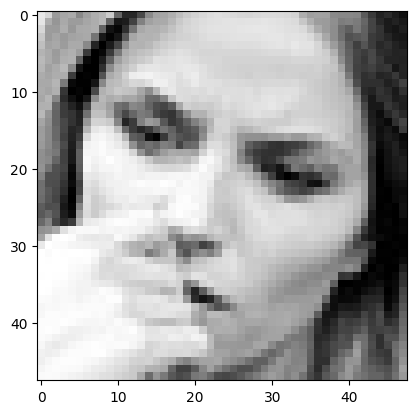

In [34]:
image = '/content/images/images/train/fear/2.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
model prediction is  disgust


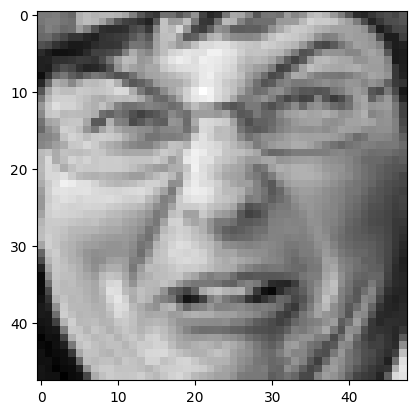

In [35]:
image = '/content/images/images/train/disgust/299.jpg'
print("original image is of disgust")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
model prediction is  happy


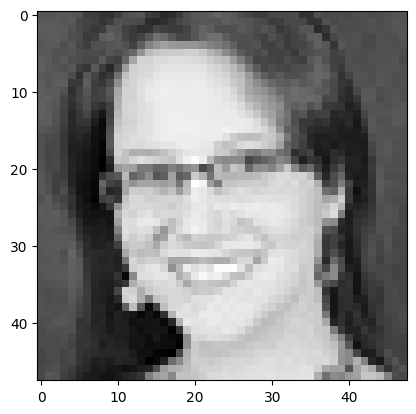

In [36]:
image = '/content/images/images/train/happy/7.jpg'
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
model prediction is  neutral


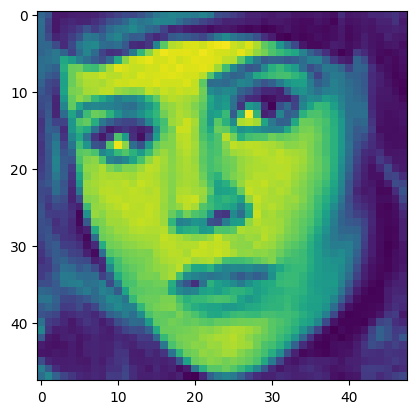

In [37]:
image = '/content/images/images/validation/neutral/10033.jpg'
print("original image is of neutral")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48))

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
model prediction is  fear


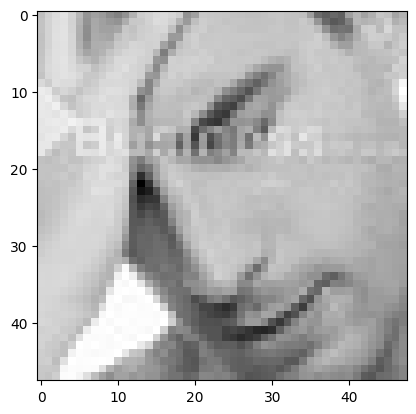

In [38]:
image = '/content/images/images/validation/fear/10189.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

FileUpload(value={}, accept='.jpg,.png', description='Upload')

Button(description='Upload Image and Predict', style=ButtonStyle())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Model prediction is: neutral


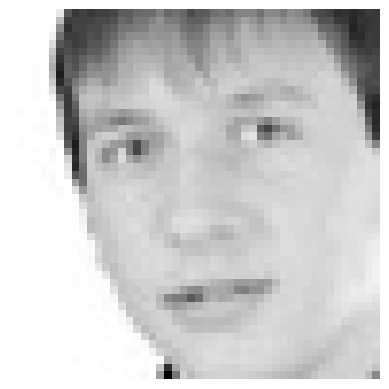

In [40]:
import ipywidgets as widgets
from IPython.display import display
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io

# Load your model (modify with your actual model path)
model = load_model('/content/facialemotionmodel.h5')

# Modify the labels list based on your model
label = ['fear', 'neutral']  # Update with actual labels for binary classification

# Function to process the uploaded image
def process_image(uploaded_image):
    img = Image.open(io.BytesIO(uploaded_image['content']))
    img = img.resize((48, 48)).convert('L')  # Resize to 48x48 and convert to grayscale
    img = np.array(img) / 255.0  # Normalize the image
    img = img.reshape(1, 48, 48, 1)  # Reshape for the model input
    return img

# Function to handle the button click and make predictions
def on_button_click(b):
    if uploader.value:
        uploaded_image = list(uploader.value.values())[0]  # Access the first uploaded file
        img = process_image(uploaded_image)

        # Predict
        pred = model.predict(img)

        # For binary classification, check the probability of the positive class
        if pred[0][0] > 0.5:  # if the model predicts 'fear' (adjust based on your model's output)
            pred_label = label[0]
        else:  # else it predicts 'neutral'
            pred_label = label[1]

        # Display result
        print(f"Model prediction is: {pred_label}")

        # Display the image
        plt.imshow(img.reshape(48, 48), cmap='gray')
        plt.axis('off')
        plt.show()

# Create a file uploader widget
uploader = widgets.FileUpload(
    accept='.jpg,.png',  # Accepts image files only
    multiple=False  # Only single file at a time
)

# Create a button to trigger prediction
button = widgets.Button(description="Upload Image and Predict")
button.on_click(on_button_click)

# Display the uploader and button
display(uploader, button)